# Face Recognition

### Dependencies

In [1]:
!pip install tensorflow==2.10.1 tensorflow-gpu==2.10.1 opencv-python matplotlib

  Using cached tensorflow-2.10.1-cp39-cp39-win_amd64.whl (455.9 MB)
  Using cached tensorflow_gpu-2.10.1-cp39-cp39-win_amd64.whl (455.9 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1
  Attempting uninstall: gast
    F

In [1]:
#importing the dependencies required
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

#importing tensorflow - functional api
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

### Folder Structure

In [2]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
POS_PATH

'data\\positive'

In [8]:
#Creating directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

### Working on dataset

In [9]:
# Dataset link: http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [12]:
# Extracting the compressed file:
!tar -xf lfw.tgz

In [14]:
# Moving the dataset to negative images directory:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

### Collecting the postive and anchor images

In [3]:
#uniform unique identifier
import uuid

In [8]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Cut down frame to 250x250 pixels
    frame = frame[120:120+250, 200:200+250, :]
    
    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imagname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imagname, frame)
        
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imagname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imagname, frame)
        
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
#Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

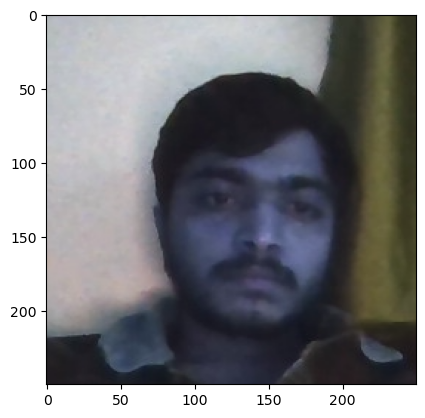

In [5]:
plt.imshow(frame)

### Get image directories

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [17]:
dir_test = anchor.as_numpy_iterator()

In [18]:
print(dir_test.next())

b'data\\anchor\\72152182-8de6-11ed-b2ef-cd0888e9346f.jpg'


### Preprocessing

In [3]:
def preprocess(file_path):
     # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [19]:
img = preprocess('data\\anchor\\72152182-8de6-11ed-b2ef-cd0888e9346f.jpg')

In [20]:
img.numpy().max()

0.84607846

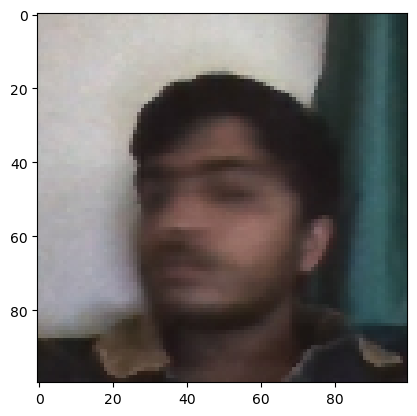

In [21]:
plt.imshow(img)

In [ ]:
dataset.map(preprocess)

### Creating labelled dataset

In [6]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [9]:
samples = data.as_numpy_iterator()

In [10]:
exampple = samples.next()

In [26]:
exampple

(b'data\\anchor\\2ce104ef-8de6-11ed-b4ef-cd0888e9346f.jpg',
 b'data\\positive\\6d04ddc8-8de6-11ed-9e28-cd0888e9346f.jpg',
 1.0)

### Train Test Partition

In [11]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [12]:
res = preprocess_twin(*exampple)

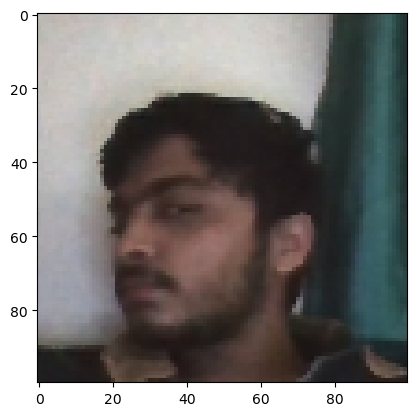

In [29]:
plt.imshow(res[1])

In [30]:
res[2]

1.0

In [13]:
# dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [14]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [15]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model

### Embedding Layer

In [34]:
inp = Input(shape=(100,100,3), name='input_image')

In [35]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [36]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [37]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [38]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [39]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [41]:
model = Model(inputs=[inp], outputs=[d1], name='embedding')

In [42]:
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [43]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [44]:
embedding = make_embedding()

In [45]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

### Distance Layer

In [21]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [22]:
l1 = L1Dist()

In [49]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

## Siamese Model

In [50]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [51]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [53]:
siamese_layer = L1Dist()

In [54]:
distances = siamese_layer(inp_embedding, val_embedding)

In [55]:
classifier = Dense(1, activation='sigmoid')(distances)

In [56]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [57]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [58]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [59]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [60]:
siamese_model = make_siamese_model()

In [61]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## Training the model

### Loss and optimizer

In [62]:
# Setup loss and potimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [63]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### Model Checkpointing

In [64]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### Build train step function

In [65]:
test_batch = train_data.as_numpy_iterator()

In [66]:
batch_1 = test_batch.next()

In [67]:
X = batch_1[:2]

In [68]:
y = batch_1[2]

In [69]:
y

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [70]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### Training Loop

In [4]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [72]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### Training the model

In [73]:
EPOCHS = 60

In [74]:
train(train_data, EPOCHS)


 Epoch 1/60
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
24/24 [==============================] - 1060s 45s/step
0.47726306 0.2628205 1.0

 Epoch 2/60
24/24 [==============================] - 904s 38s/step
0.38391513 0.8701299 0.9852941

 Epoch 3/60
24/24 [==============================] - 897s 37s/step
0.010518894 0.9117647 0.99358976

 Epoch 4/60
24/24 [==============================] - 882s 37s/step
0.062101163 0.9875 1.0

 Epoch 5/60
24/24 [==============================] - 813s 34s/step
0.00043440727 0.9936306 0.9936306

 Epoch 6/60
24/24 [==============================] - 809s 33s/step
9.8593526e-05 0.9876543 1.0

 Epoch 7/60
1/1 [==============================] - 3s 3s/step


24/24 [==============================] - 816s 34s/step
0.007463606 0.96153843 1.0

 Epoch 8/60
24/24 [==============================] - 790s 33s/step
0.02246004 0.9814815 1.0

 Epoch 9/60
24/24 [==============================] - 829s 35s/step
1.1295145e-05 0.9935484 1.0

 Epoch 10/60
24/24 [==============================] - 815s 34s/step
0.00052121485 1.0 1.0

 Epoch 11/60
24/24 [==============================] - 817s 34s/step
0.0048866733 1.0 1.0

 Epoch 12/60
24/24 [==============================] - 776s 32s/step
0.00011280956 1.0 1.0

 Epoch 13/60
1/1 [==============================] - 3s 3s/step


24/24 [==============================] - 822s 35s/step
0.9228125 1.0 1.0

 Epoch 14/60
24/24 [==============================] - 803s 34s/step
0.04187599 0.9244186 0.99375

 Epoch 15/60
24/24 [==============================] - 785s 33s/step
0.27344126 0.9875776 1.0

 Epoch 16/60
24/24 [==============================] - 805s 33s/step
0.00051515753 1.0 1.0

 Epoch 17/60
24/24 [==============================] - 790s 33s/step
0.00029801225 1.0 1.0

 Epoch 18/60
24/24 [==============================] - 821s 34s/step
0.024642153 1.0 1.0

 Epoch 19/60
1/1 [==============================] - 3s 3s/step


24/24 [==============================] - 771s 32s/step
0.0010670237 1.0 1.0

 Epoch 20/60
24/24 [==============================] - 789s 33s/step
0.00025144464 1.0 1.0

 Epoch 21/60
24/24 [==============================] - 787s 33s/step
2.3544177e-05 1.0 1.0

 Epoch 22/60
24/24 [==============================] - 1020s 43s/step
0.000106673855 1.0 1.0

 Epoch 23/60
 5/24 [=====>........................] - ETA: 18:17

KeyboardInterrupt: 

### Evaluating the model

In [16]:
from tensorflow.keras.metrics import Precision, Recall

In [17]:
# Predictions
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [18]:
y_hat = siamese_model.predict([test_input, test_val])

NameError: name 'siamese_model' is not defined

In [78]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0]

In [79]:
y_true

array([0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.],
      dtype=float32)

In [80]:
# Calculating the metrics
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [81]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [82]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 3s 3s/step
1.0 1.0


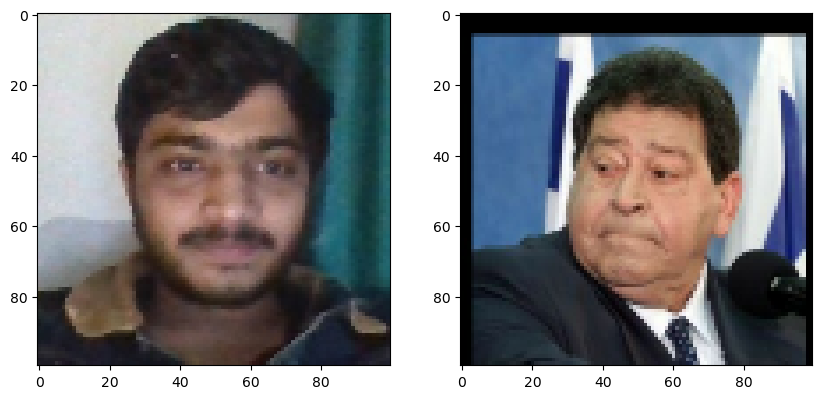

In [83]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

### Save Model

In [7]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

NameError: name 'siamese_model' is not defined

In [6]:
L1Dist

NameError: name 'L1Dist' is not defined

In [23]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [24]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 3s 3s/step


array([[1.0205170e-04],
       [2.5821805e-06],
       [6.5179279e-06],
       [1.5738538e-05],
       [7.1043586e-03],
       [2.5336357e-04],
       [9.9558824e-01],
       [9.7329241e-01],
       [4.7274163e-05],
       [3.8176927e-07],
       [2.8617544e-05],
       [2.7351083e-05],
       [9.9769115e-01],
       [9.9903226e-01],
       [1.0000000e+00],
       [9.9999684e-01]], dtype=float32)

In [12]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### Real Time Test

### Verification Function

In [25]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [26]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    

    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 569ms/step
True


In [27]:
np.sum(np.squeeze(results) > 0.9)

17

In [28]:
results

[array([[0.5937728]], dtype=float32),
 array([[0.99999917]], dtype=float32),
 array([[0.9999978]], dtype=float32),
 array([[0.7606953]], dtype=float32),
 array([[0.7606953]], dtype=float32),
 array([[0.47535717]], dtype=float32),
 array([[0.77276766]], dtype=float32),
 array([[0.58952904]], dtype=float32),
 array([[0.58952904]], dtype=float32),
 array([[0.8833301]], dtype=float32),
 array([[0.8833301]], dtype=float32),
 array([[0.9999996]], dtype=float32),
 array([[0.9999996]], dtype=float32),
 array([[0.9999996]], dtype=float32),
 array([[0.9999996]], dtype=float32),
 array([[0.06488516]], dtype=float32),
 array([[0.09695972]], dtype=float32),
 array([[0.99999917]], dtype=float32),
 array([[0.99999887]], dtype=float32),
 array([[0.9999997]], dtype=float32),
 array([[0.00010745]], dtype=float32),
 array([[0.01359548]], dtype=float32),
 array([[0.07653028]], dtype=float32),
 array([[0.9999971]], dtype=float32),
 array([[0.9999983]], dtype=float32),
 array([[0.9999991]], dtype=float32),
